### Part 1: Analyzing Best-Seller Trends Across Product Categories

**Objective**: Understand the relationship between product categories and their best-seller status.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Loading the dataset
df = pd.read_csv("amz_pred_dataset.csv")

In [ ]:
df.head()

In [ ]:
df.shape

In [27]:
df.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [ ]:
df.dtypes

In [ ]:
pd.set_option('display.max_rows', None)

1. **Crosstab Analysis**:
    - Create a crosstab between the product `category` and the `isBestSeller` status.

In [3]:
# Crosstab 
crosstab_result = pd.crosstab(df['category'], df['isBestSeller']) 
crosstab_sorted = crosstab_result.sort_values(True, ascending=False)

In [ ]:
pd.reset_option('display.max_rows')

In [4]:
crosstab_result

isBestSeller,False,True
category,,
3D Printers,247,1
3D Printing & Scanning,4065,2
Abrasive & Finishing Products,245,5
Action Cameras,1696,1
Adapters,251,3
...,...,...
Wind Instruments,243,7
Window Treatments,234,5
Women,17559,213


In [5]:
crosstab_sorted

isBestSeller,False,True
category,,
Grocery,9008,556
Health & Personal Care,9017,552
Baby,14709,341
Sports & Outdoors,835935,330
Power & Hand Tools,8353,306
...,...,...
Downhill Ski Boots,1284,0
Digital Frames,774,0
Motorbike Chassis,107,0


- Are there categories where being a best-seller is more prevalent? 

In [14]:
# Calculate the proportion of best-sellers
crosstab_sorted['proportion_best_sellers'] = (crosstab_result[True] / crosstab_result.sum(axis=1)) * 100

# Sort by the proportion of best-sellers in descending order
crosstab_sorted_proportion = crosstab_sorted.sort_values('proportion_best_sellers', ascending=False)

crosstab_sorted_proportion.head()



isBestSeller,False,True,proportion_best_sellers
category,,,
Grocery,9008,556,5.813467
Smart Home Security & Lighting,98,6,5.769231
Health & Personal Care,9017,552,5.768628
Mobile Phone Accessories,248,11,4.247104
Power & Hand Tools,8353,306,3.533895


2. **Statistical Tests**:

    - Compute Cramér's V to understand the strength of association between best-seller status and category.

In [7]:
from scipy.stats.contingency import association

In [15]:

# Computing the association between variables  using the "cramer" method
association(crosstab_result, method="cramer")

0.1222829439760564

The Cramér's V value of 0.122 suggests a weak association between the two variables. Though statistically significant, the strength of this relationship is not very strong in practical terms. The "category" alone is not a strong predictor of best-seller status.

    - Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.

In [16]:
from scipy.stats import chi2_contingency

# Chi-square test 
chi2_statistic, chi2_p_value, _, _ = chi2_contingency(crosstab_result)

chi2_statistic, chi2_p_value


print(f"Chi-square statistic = {chi2_statistic}")
print(f"p-value = {chi2_p_value}")

Chi-square statistic = 36540.20270061387
p-value = 0.0


The p-value = 0   suggests that there is a significant association between the variables.
There is a statistically significant relationship between the category and isBestSeller variables.

3. **Visualizations**:
	- Visualize the relationship between product categories and the best-seller status using a stacked bar chart.

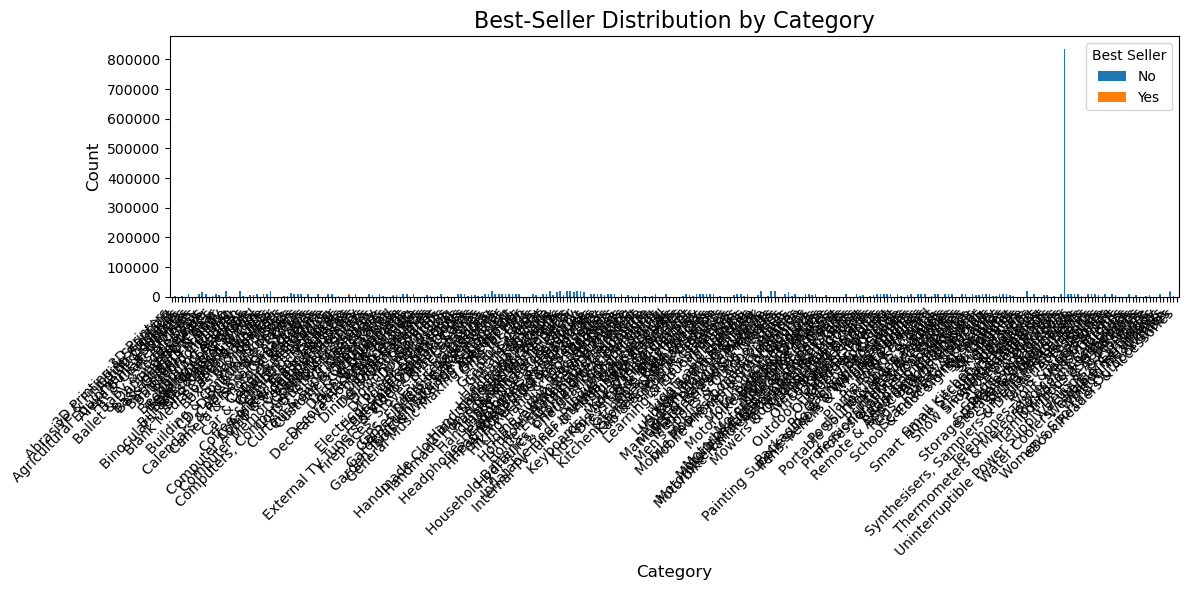

In [17]:
import matplotlib.pyplot as plt

# Prepare data
crosstab_result.plot(kind='bar', stacked=True, figsize=(12, 6))

# Add labels and title
plt.title('Best-Seller Distribution by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Best Seller', labels=['No', 'Yes'])
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()


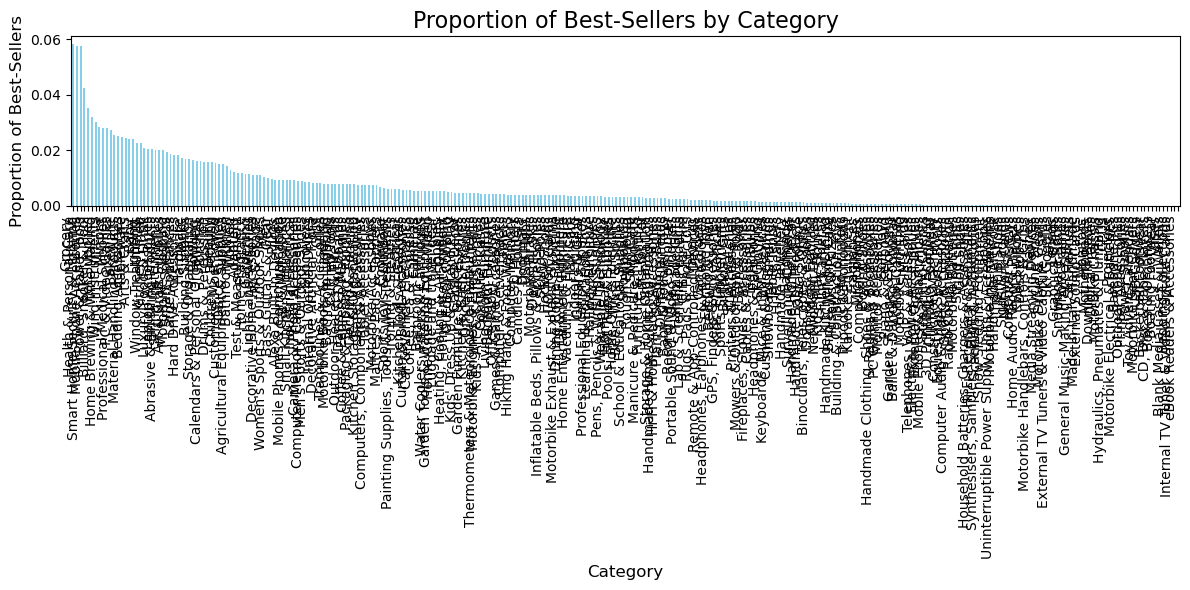

In [22]:
# Calculate proportions
crosstab_sorted['proportion_best_sellers'] = crosstab_sorted[True] / crosstab_sorted.sum(axis=1)

# Bar plot for proportions
crosstab_sorted['proportion_best_sellers'].sort_values(ascending=False).plot(
    kind='bar', figsize=(12, 6), color='skyblue'
)

# Add labels and title
plt.title('Proportion of Best-Sellers by Category', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Proportion of Best-Sellers', fontsize=12)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()

plt.show()


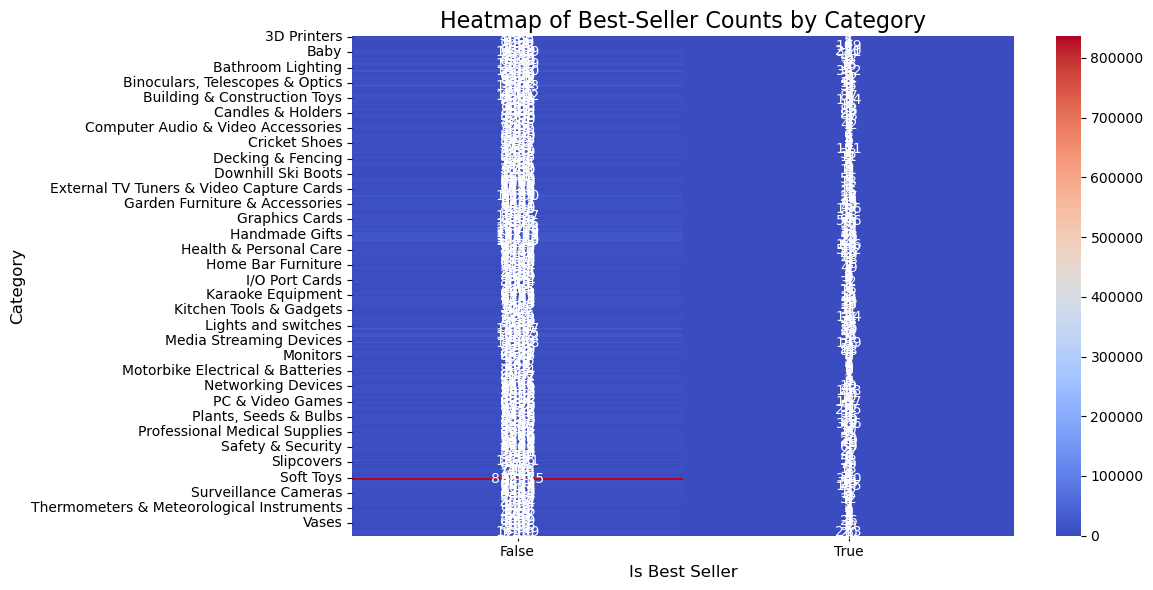

In [25]:
plt.figure(figsize=(12, 6))
sns.heatmap(crosstab_result, annot=True, fmt='d', cmap='coolwarm', cbar=True)
plt.title('Heatmap of Best-Seller Counts by Category', fontsize=16)
plt.xlabel('Is Best Seller', fontsize=12)
plt.ylabel('Category', fontsize=12)
plt.tight_layout()
plt.show()


### Part 2: Exploring Product Prices and Ratings Across Categories and Brands

**Objective**: Investigate how different product categories influence product prices.

0. **Preliminary Step: Remove outliers in product prices.**

	For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.
	
	*Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.*

In [31]:
# Calculate Q1, Q3, and IQR
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for the non-outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter the DataFrame to remove outliers
df_cleaned = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Display results
print(f"Original data shape: {df.shape}")
print(f"Cleaned data shape: {df_cleaned.shape}")

Original data shape: (2443651, 9)
Cleaned data shape: (2115963, 9)


1. **Violin Plots**:
    - Use a violin plot to visualize the distribution of `price` across different product `categories`. Filter out the top 20 categories based on count for better visualization.
    - Which product category tends to have the highest median price? Don't filter here by top categories.


/tmp/ipykernel_16977/1630866135.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_top_20, x='price', y='category', palette="coolwarm")


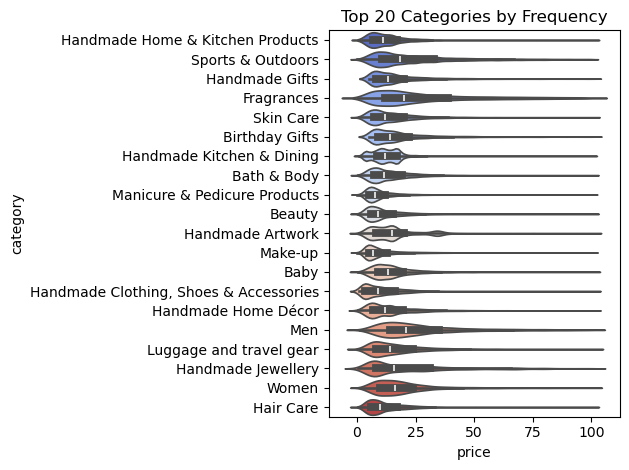

In [42]:
# Get the top 20 categories by frequency
top_categories = df_cleaned['category'].value_counts().head(20).index

# Filter the DataFrame
df_top_20 = df_cleaned[df_cleaned['category'].isin(top_categories)]

# Create the violin plot
sns.violinplot(data=df_top_20, x='price', y='category', palette="coolwarm")
plt.title("Top 20 Categories by Frequency")
plt.tight_layout()
plt.show()

2. **Bar Charts**:
    - Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
    - Which product category commands the highest average price? Don't filter here by top categories.

/tmp/ipykernel_16977/967255567.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_top_10, x='price', y='category', palette="coolwarm")


<Axes: xlabel='price', ylabel='category'>

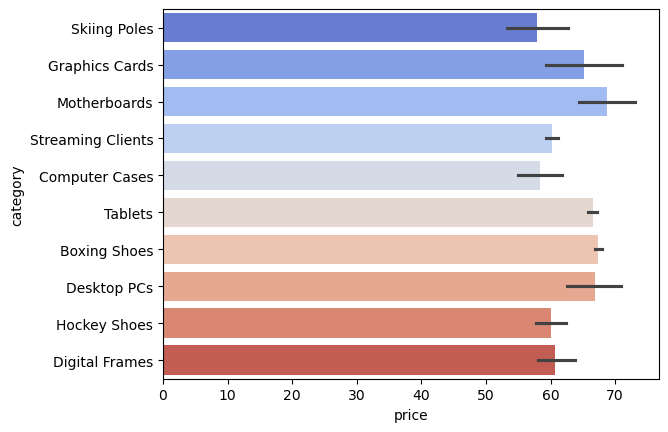

In [44]:
# Get the top 10 categories by average price
top_categories = df_cleaned.groupby('category')['price'].mean().sort_values(ascending=False).head(10).index

# Filter the DataFrame
df_top_10 = df_cleaned[df_cleaned['category'].isin(top_categories)]

# Plotting a bar plot to visualize the average 'price' for each of the top 10 categories. 
sns.barplot(data=df_top_10, x='price', y='category', palette="coolwarm")


3. **Box Plots**:
    - Visualize the distribution of product `ratings` based on their `category` using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
    - Which category tends to receive the highest median rating from customers? Don't filter here by top categories.

/tmp/ipykernel_16977/1590056702.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_top_10, x='category', y='stars', palette="coolwarm")


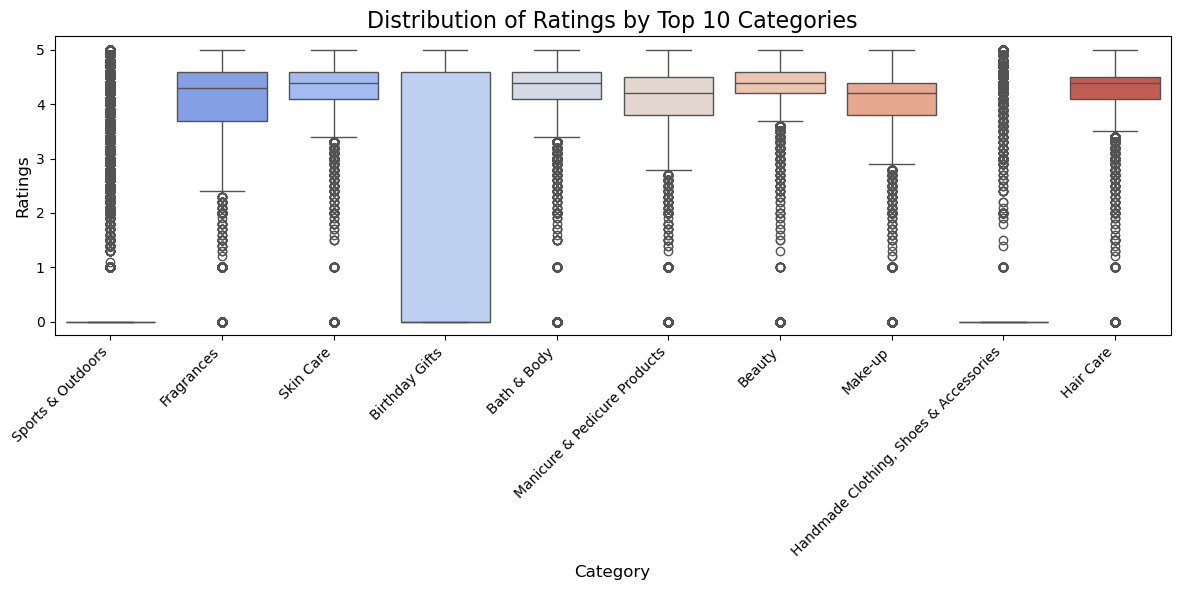

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Get the top 10 categories by count
top_categories = df['category'].value_counts().head(10).index

# Step 2: Filter the dataset
df_top_10 = df[df['category'].isin(top_categories)]

# Step 3: Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_top_10, x='category', y='stars', palette="coolwarm")
plt.title('Distribution of Ratings by Top 10 Categories', fontsize=16)
plt.xlabel('Category', fontsize=12)
plt.ylabel('Ratings', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotate category labels for better readability
plt.tight_layout()

plt.show()



### Part 3: Investigating the Interplay Between Product Prices and Ratings

**Objective**: Analyze how product ratings (`stars`) correlate with product prices.


1. **Correlation Coefficients**:
    - Calculate the correlation coefficient between `price` and `stars`.
    - Is there a significant correlation between product price and its rating?

In [ ]:
# Calculating the Pearson correlation coefficient between 'price' and 'stars' columns
correlation = df['price'].corr(df['stars'])
correlation

-0.1249067326214861

In [65]:
# Calculating the Spearman rank correlation between 'price' and 'stars' 
correlation = df['price'].corr(df['stars'], method='spearman')
correlation

-0.1331642546243379

A negative correlation indicates that when the price increases the rating decreases, but as the correlation is very close to zero, we can say that this is not very notable.

Key Insights:
1. Pearson Correlation Coefficient: -0.1249

    Pearson's correlation measures the linear relationship between two variables.
    A value of -0.1249 indicates a very weak negative linear relationship between the two variables.
    This means that as one variable increases, the other tends to decrease slightly, but the relationship is almost negligible in practical terms.

2. Spearman Rank Correlation: -0.1331

    Spearman's rank correlation measures the monotonic relationship (how well the variables maintain a consistent rank order).
    A value of -0.1331 indicates a very weak negative monotonic relationship.
    This suggests that, overall, higher ranks in one variable are slightly associated with lower ranks in the other, but the effect is very small.

Comparing the Two:

    Both coefficients are negative and close in magnitude (-0.1249 and -0.1331), suggesting:
        A consistent very weak negative relationship between the variables.
        The relationship is not strictly linear but might have slight non-linear tendencies, as Spearman is less sensitive to linearity than Pearson.
    The small difference between the two coefficients indicates that outliers or non-linearity do not strongly affect the data.

Possible Conclusions:

    No Strong Relationship: The variables are not strongly related, whether linearly or monotonically.
    Weak Negative Association: There is a tendency for one variable to decrease slightly as the other increases, but this relationship is so weak that it may not be meaningful or actionable.

	
2. **Visualizations**:
    - Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
    - Use a correlation heatmap to visualize correlations between all numerical variables.
    - Examine if product prices typically follow a normal distribution using a QQ plot. 


<Axes: xlabel='price', ylabel='stars'>

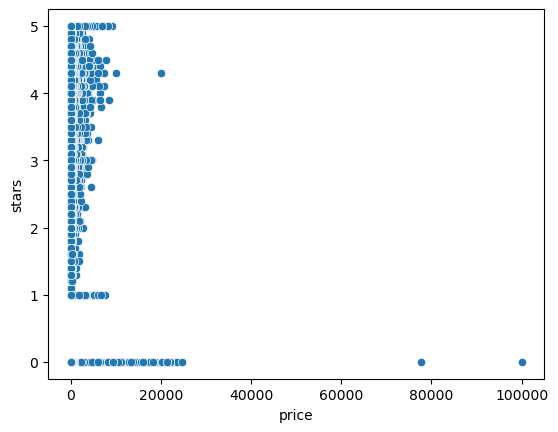

In [68]:
# scatter plot 
sns.scatterplot(data=df, y='stars', x='price')


**Bonus**: 

- Do the same analysis without taking out the outliers. What are your insights?